# Workflow
1. Define Problem
2. Load Data
3. Data Cleaning
4. Modeling Building
5. Build VoteClassifier
6. Evaluation
7. Pickle the best Classifier
8. Conclusion


## 1. Define Problem
> Predict the pitch_name based on release_speed, release_pos_x, release_pos_z, release_spin_rate, (optional: balls and strikes)

In [62]:
# data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

## 2. Load Data

In [63]:
df = pd.read_csv("/Users/gihonglee/Desktop/DREAM/projects/MLB_project/data/statcast_2017.csv")

In [71]:
df[['pitch_name']].value_counts(normalize= True)

pitch_name     
4-Seam Fastball    0.347745
Slider             0.162316
2-Seam Fastball    0.129517
Changeup           0.099332
Sinker             0.078767
Curveball          0.078671
Cutter             0.053005
Knuckle Curve      0.029668
Split-Finger       0.016476
Knuckleball        0.003685
Forkball           0.000344
Eephus             0.000258
Pitch Out          0.000162
Screwball          0.000054
dtype: float64

<AxesSubplot:xlabel='pitch_name'>

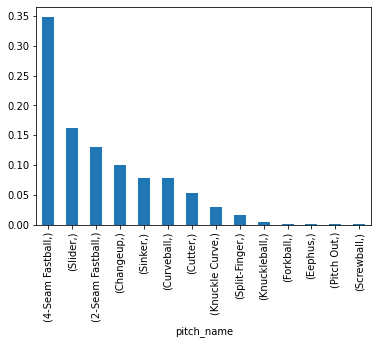

In [72]:
df[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

From above we can see 14 types of pitch. For more accurate result, we drop low 5 types, Knuckleball, Forkball, Eephus, Pitch Out and Screwball

## 3. Data Cleaning

In [56]:
df = df[['pitch_name','release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate']]

In [57]:
print(f"size before droping null values {df.shape}")
df = df.dropna()
print(f"size after droping null values {df.shape}")

size before droping null values (721244, 5)
size after droping null values (703076, 5)


In [58]:
df = df.sample(n=1000, random_state=1)
df_X = df.drop('pitch_name',axis = 1)

pca = PCA(n_components=2)
components = pca.fit_transform(df_X)

In [59]:
print(pca.explained_variance_ratio_)

[9.99512558e-01 4.39563331e-04]


In [60]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df.pitch_name, hover_name = df.pitch_name)
fig.show()